# 04 - Exploration SQL

Analyse exploratoire des données Silver avec SparkSQL.

## Configuration

In [1]:
from config import get_s3_path, create_spark_session

SILVER_PATH = get_s3_path("silver", "flights")

spark = create_spark_session("ExplorationSQL")

df = spark.read.format("delta").load(SILVER_PATH)
df.createOrReplaceTempView("flights")

print(f"✅ {df.count():,} lignes chargées")

✅ Configuration chargée depuis .env
:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
org.apache.spark#spark-hadoop-cloud_2.12 added as a dependency
io.delta#delta-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b752b90d-d9d3-476f-bde4-f87624787057;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-hadoop-cloud_2.12;3.5.3 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apache.hadoop#hadoop-client-api;3.3.4 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found commons-logging#commons-logging;1.1.3 in central
	found com.google.c

✅ Spark Session 'ExplorationSQL' configurée


26/01/23 15:39:05 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
26/01/23 15:39:24 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl
26/01/23 15:39:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


✅ 547,580 lignes chargées


## Schéma des données

In [2]:
df.printSchema()

root
 |-- event_timestamp: timestamp (nullable = true)
 |-- icao24: string (nullable = true)
 |-- callsign: string (nullable = true)
 |-- origin_country: string (nullable = true)
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- velocity_kmh: double (nullable = true)
 |-- altitude_meters: float (nullable = true)
 |-- on_ground: boolean (nullable = true)
 |-- category: integer (nullable = true)



## Statistiques par pays

In [3]:
spark.sql("""
    SELECT 
        origin_country,
        COUNT(*) AS nb_observations,
        ROUND(AVG(altitude_meters), 2) AS avg_altitude,
        ROUND(AVG(velocity_kmh), 2) AS avg_velocity
    FROM flights
    WHERE origin_country IS NOT NULL
    GROUP BY origin_country
    ORDER BY nb_observations DESC
    LIMIT 10
""").show(truncate=False)

+--------------+---------------+------------+------------+
|origin_country|nb_observations|avg_altitude|avg_velocity|
+--------------+---------------+------------+------------+
|United States |278280         |6170.61     |510.87      |
|Canada        |22585          |7417.68     |501.23      |
|United Kingdom|21025          |6947.35     |587.85      |
|Germany       |18154          |5970.8      |508.01      |
|Turkey        |17513          |8744.81     |718.21      |
|Ireland       |14989          |8146.28     |656.7       |
|China         |11551          |8383.76     |700.36      |
|India         |11514          |7101.58     |587.93      |
|France        |11250          |6994.36     |598.57      |
|Malta         |8782           |8779.8      |674.65      |
+--------------+---------------+------------+------------+



## Avions au sol vs en vol

In [4]:
spark.sql("""
    SELECT 
        on_ground,
        COUNT(*) AS count,
        ROUND(AVG(velocity_kmh), 2) AS avg_velocity
    FROM flights
    GROUP BY on_ground
""").show()

+---------+------+------------+
|on_ground| count|avg_velocity|
+---------+------+------------+
|    false|505988|      615.87|
|     true| 51513|       18.43|
+---------+------+------------+



## Distribution des altitudes

In [5]:
spark.sql("""
    SELECT 
        CASE 
            WHEN altitude_meters IS NULL THEN 'NULL'
            WHEN altitude_meters < 1000 THEN '0-1000m'
            WHEN altitude_meters < 5000 THEN '1000-5000m'
            WHEN altitude_meters < 10000 THEN '5000-10000m'
            ELSE '10000m+'
        END AS altitude_range,
        COUNT(*) AS count
    FROM flights
    GROUP BY 1
    ORDER BY count DESC
""").show()

+--------------+------+
|altitude_range| count|
+--------------+------+
|       10000m+|203064|
|   5000-10000m|119847|
|    1000-5000m|111925|
|       0-1000m| 81390|
|          NULL| 51117|
+--------------+------+



## Requête Batch avec Window Function

Analyse de l'évolution de chaque avion : altitude précédente, variation, et rang par vitesse dans son pays.

In [6]:
spark.sql("""
    SELECT
        icao24,
        callsign,
        origin_country,
        event_timestamp,
        altitude_meters,
        LAG(altitude_meters) OVER (PARTITION BY icao24 ORDER BY event_timestamp) AS prev_altitude,
        altitude_meters - LAG(altitude_meters) OVER (PARTITION BY icao24 ORDER BY event_timestamp) AS altitude_change,
        ROUND(AVG(altitude_meters) OVER (PARTITION BY icao24 ORDER BY event_timestamp ROWS BETWEEN 5 PRECEDING AND CURRENT ROW), 2) AS rolling_avg_altitude,
        RANK() OVER (PARTITION BY origin_country ORDER BY velocity_kmh DESC) AS velocity_rank_in_country
    FROM flights
    WHERE icao24 IS NOT NULL AND altitude_meters IS NOT NULL
    ORDER BY icao24, event_timestamp
    LIMIT 20
""").show(truncate=False)

+------+--------+--------------+-------------------+---------------+-------------+---------------+--------------------+------------------------+
|icao24|callsign|origin_country|event_timestamp    |altitude_meters|prev_altitude|altitude_change|rolling_avg_altitude|velocity_rank_in_country|
+------+--------+--------------+-------------------+---------------+-------------+---------------+--------------------+------------------------+
|00428c|NULL    |Zimbabwe      |2026-01-23 15:06:46|2225.04        |NULL         |NULL           |2225.04             |1                       |
|00428c|NULL    |Zimbabwe      |2026-01-23 15:07:03|2186.94        |2225.04      |-38.100098     |2205.99             |3                       |
|00428c|5YJDE   |Zimbabwe      |2026-01-23 15:07:24|2125.98        |2186.94      |-60.95996      |2179.32             |2                       |
|00428c|5YJDE   |Zimbabwe      |2026-01-23 15:07:36|2095.5         |2125.98      |-30.47998      |2158.36             |4          

## Aperçu des données

In [7]:
df.show(10, truncate=False)

26/01/23 15:40:42 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl


+-------------------+------+--------+--------------+---------+--------+------------+---------------+---------+--------+
|event_timestamp    |icao24|callsign|origin_country|longitude|latitude|velocity_kmh|altitude_meters|on_ground|category|
+-------------------+------+--------+--------------+---------+--------+------------+---------------+---------+--------+
|2026-01-23 14:10:37|407b02|GOLD31  |United Kingdom|-3.4535  |53.5663 |0.22        |NULL           |true     |NULL    |
|2026-01-23 14:10:37|a89fda|FFT1974 |United States |-97.0357 |32.8889 |0.22        |NULL           |true     |NULL    |
|2026-01-23 14:10:37|a7cfe3|NKS450  |United States |-81.3157 |28.4341 |0.0         |NULL           |true     |NULL    |
|2026-01-23 14:10:37|a235f5|CXK230  |United States |-80.6815 |35.4429 |147.06      |777.24         |false    |NULL    |
|2026-01-23 14:10:37|a40e30|VJA360  |United States |-87.362  |42.6088 |440.82      |3345.18        |false    |NULL    |
|2026-01-23 14:10:37|a1b535|UAL47   |Uni

## Visualisations avec Seaborn/Pandas

Analyses visuelles des données Silver converties en Pandas (échantillon pour limiter la mémoire).

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

# Chargement des données Silver_ML (contient flight_phase)
SILVER_ML_PATH = get_s3_path("silver", "flights_ml")
df_ml = spark.read.format("delta").load(SILVER_ML_PATH)

# Conversion Spark -> Pandas (échantillon de 10000 lignes)
pdf = df_ml.sample(fraction=0.1, seed=42).limit(10000).toPandas()
print(f"Echantillon: {len(pdf)} lignes depuis Silver_ML")

26/01/23 15:41:05 ERROR NonFateSharingFuture: Failed to get result from future
scala.runtime.NonLocalReturnControl


Echantillon: 10000 lignes depuis Silver_ML


### 1. Distribution des altitudes (histogramme)

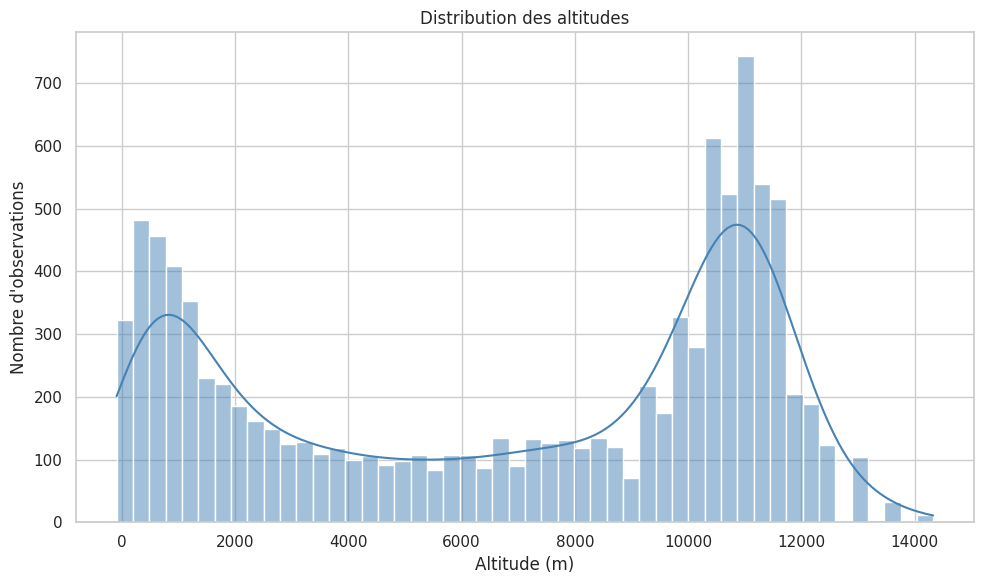

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=pdf, x="altitude_meters", bins=50, kde=True, color="steelblue")
plt.xlabel("Altitude (m)")
plt.ylabel("Nombre d'observations")
plt.title("Distribution des altitudes")
plt.tight_layout()
plt.show()

### 2. Répartition des phases de vol (pie chart)

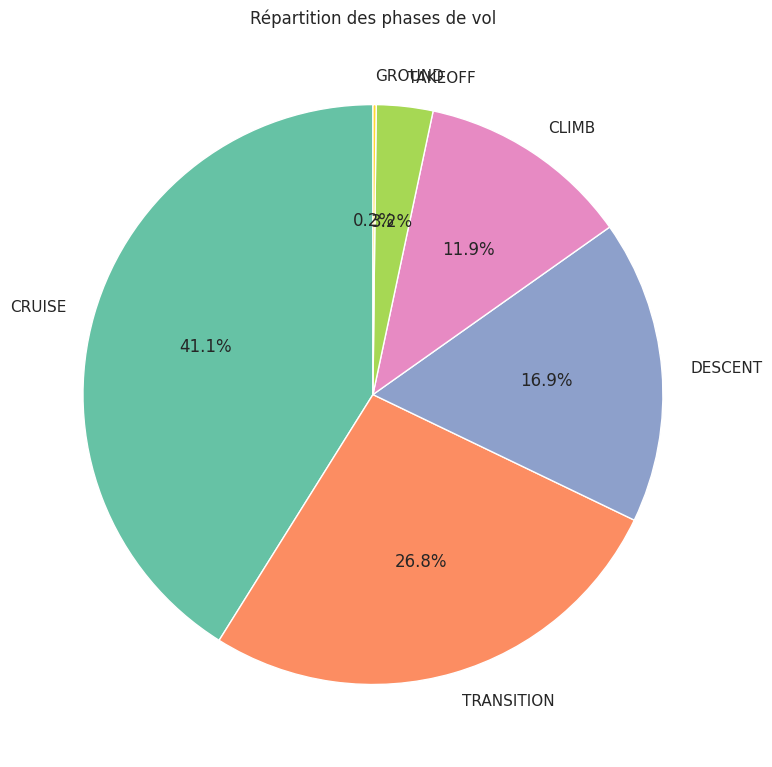

In [10]:
phase_counts = pdf["flight_phase"].value_counts()

plt.figure(figsize=(8, 8))
colors = sns.color_palette("Set2", len(phase_counts))
plt.pie(phase_counts, labels=phase_counts.index, autopct="%1.1f%%", colors=colors, startangle=90)
plt.title("Répartition des phases de vol")
plt.tight_layout()
plt.show()

### 3. Vitesse moyenne par pays (barplot horizontal)

/tmp/ipykernel_11010/2856500471.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=velocity_by_country.values, y=velocity_by_country.index, palette="viridis")


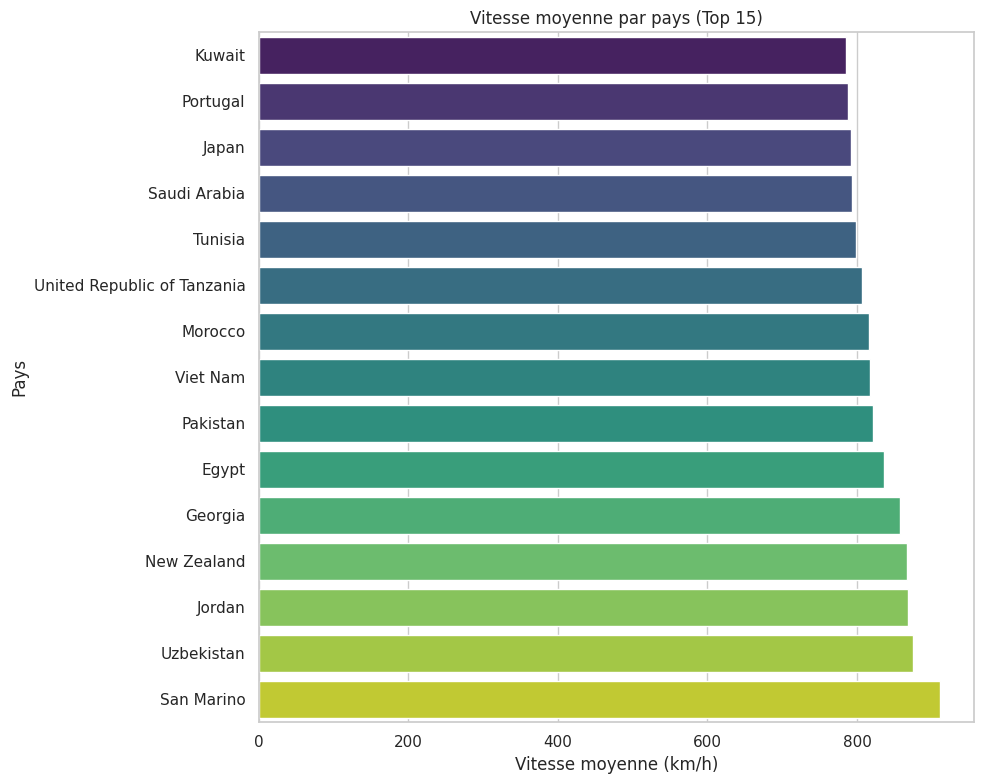

In [11]:
velocity_by_country = pdf.groupby("origin_country")["velocity_kmh"].mean().sort_values(ascending=True).tail(15)

plt.figure(figsize=(10, 8))
sns.barplot(x=velocity_by_country.values, y=velocity_by_country.index, palette="viridis")
plt.xlabel("Vitesse moyenne (km/h)")
plt.ylabel("Pays")
plt.title("Vitesse moyenne par pays (Top 15)")
plt.tight_layout()
plt.show()

### 4. Heatmap corrélation features ML

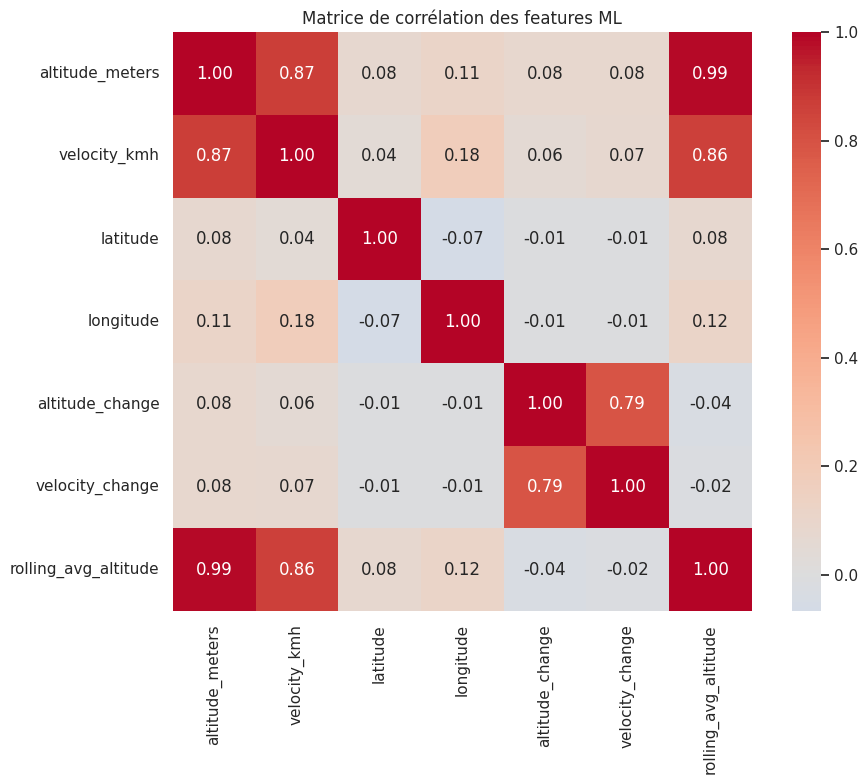

In [12]:
# Sélection des colonnes numériques pour la corrélation
numeric_cols = ["altitude_meters", "velocity_kmh", "latitude", "longitude", 
                "altitude_change", "velocity_change", "rolling_avg_altitude"]
numeric_cols_available = [c for c in numeric_cols if c in pdf.columns]

corr_matrix = pdf[numeric_cols_available].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", square=True)
plt.title("Matrice de corrélation des features ML")
plt.tight_layout()
plt.show()

### 5. Évolution temporelle du trafic (lineplot)

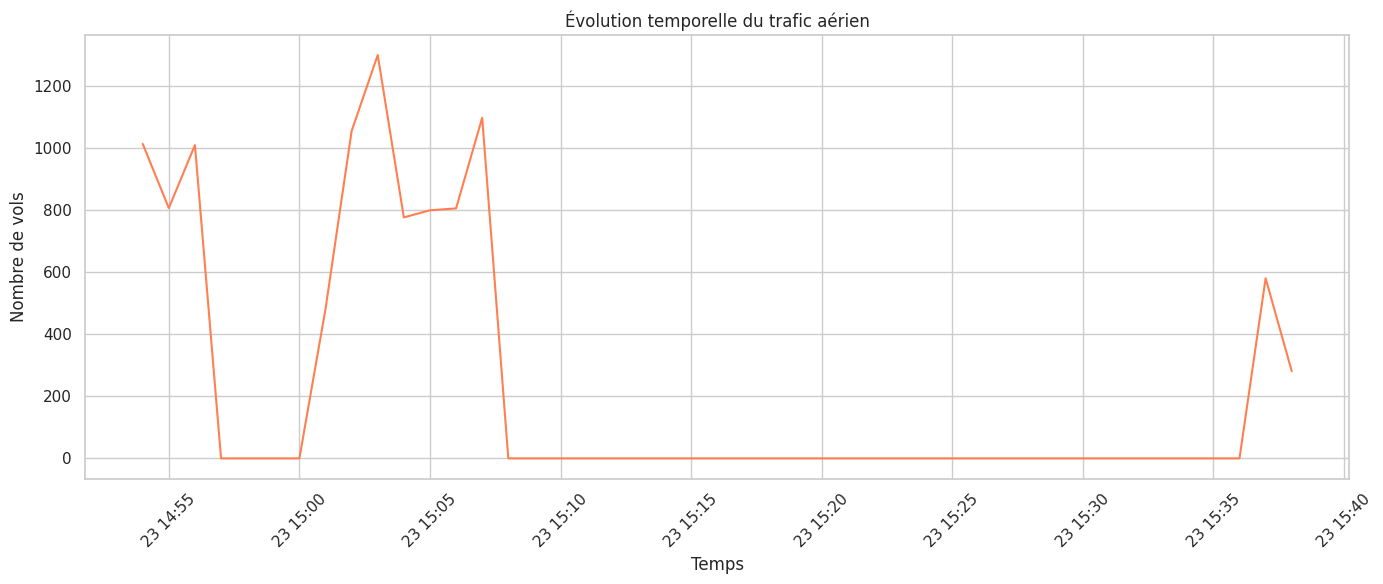

In [13]:
# Agrégation par minute pour l'évolution temporelle
pdf["event_timestamp"] = pd.to_datetime(pdf["event_timestamp"])
traffic_over_time = pdf.set_index("event_timestamp").resample("1min").size().reset_index(name="nb_flights")

plt.figure(figsize=(14, 6))
sns.lineplot(data=traffic_over_time, x="event_timestamp", y="nb_flights", color="coral")
plt.xlabel("Temps")
plt.ylabel("Nombre de vols")
plt.title("Évolution temporelle du trafic aérien")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()